In [3]:
import numpy as np


from KnackpackData import getEncoded,weights,values,max_weight
max_weight = np.float32(max_weight)
values = values.astype('float32')
weights = weights.astype('float32')



In [ ]:
from numba import njit,prange
@njit("int32(boolean[::1],boolean[::1])",nogil = True,fastmath=True)
def dominates(first, second):
    thisWeight= 0
    thisValue = 0
    otherWeight = 0
    otherValue= 0
    for i in prange(weights.size):
        if first[i]:
            thisWeight += weights[i]
            thisValue  += values[i]
        if second[i]:
            otherWeight += weights[i]
            otherValue +=values[i]
    if thisWeight>max_weight:
        thisValue = -1
    if otherWeight>max_weight:
        otherValue = -1
    if (thisValue >= otherValue and thisWeight < otherWeight) or (thisValue > otherValue and thisWeight <= otherWeight):
        return 1
    elif (thisValue <= otherValue and thisWeight > otherWeight) or (thisValue < otherValue and thisWeight >= otherWeight):
        return -1
    else:
        return 0
@njit("int32[::1](boolean[:,::1])",nogil = True,fastmath=True,parallel = True)
def getResult(pop):
    res = np.zeros(pop.size,dtype=np.int32)
    for i in prange(len(pop)):
        for j in prange(len(pop)):
            res[i] += dominates(pop[i],pop[j])
    return res

CPU times: user 2min 7s, sys: 16 ms, total: 2min 7s
Wall time: 16 s
61761


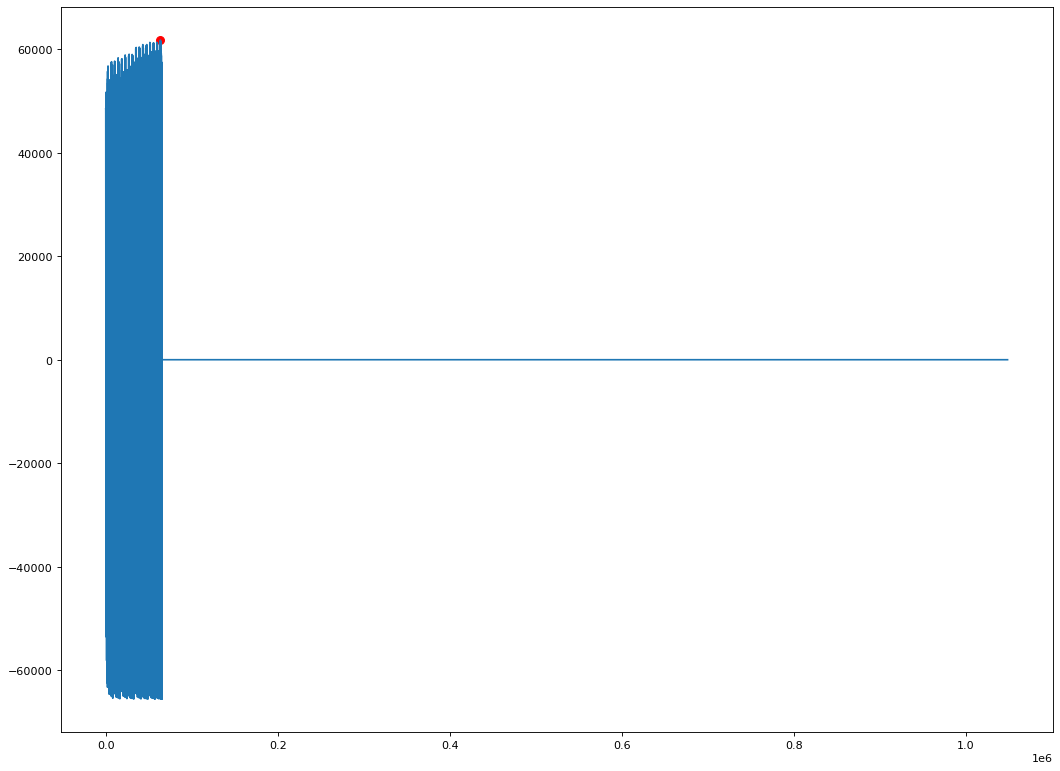

In [4]:
population = getEncoded()
%time results = getResult(population)
import matplotlib.pyplot as plt
best_index = np.argmax(results)
best_index
print(results[best_index])
plt.figure(figsize=(16, 12), dpi=80)
plt.scatter(best_index,results[best_index],c="r",s=50)
plt.plot(results)